# 필요한 모듈 import

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence

import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torch.optim import Adam
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# GPU 사용가능 여부 체크
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# 하이퍼파라미터 설정 및 시드 고정

In [3]:
# 하이퍼파라미터 설정

EPOCHS = 5 # 반복 횟수
LR = 1e-5 # 학습률
BS = 8 # 배치 크기
SEED = 41 # 랜덤 시드

In [4]:
# 함수를 정의하여 모든 시드를 사전에 고정시킴
# 앞에서 설정한 SEED(랜덤 시드) 사용

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(SEED)

# 데이터 로드

In [5]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [6]:
train

,ID,Utterance,Speaker,Dialogue_ID,Target
0,TRAIN_0000,also I was the point person on my company’s tr...,Chandler,0,neutral
1,TRAIN_0001,You must’ve had your hands full.,The Interviewer,0,neutral
2,TRAIN_0002,That I did. That I did.,Chandler,0,neutral
3,TRAIN_0003,So let’s talk a little bit about your duties.,The Interviewer,0,neutral
4,TRAIN_0004,My duties? All right.,Chandler,0,surprise
...,...,...,...,...,...
9984,TRAIN_9984,You or me?,Chandler,1038,neutral
9985,TRAIN_9985,"I got it. Uh, Joey, women don't have Adam's ap...",Ross,1038,neutral
9986,TRAIN_9986,"You guys are messing with me, right?",Joey,1038,surprise
9987,TRAIN_9987,Yeah.,All,1038,neutral


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9989 entries, 0 to 9988
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           9989 non-null   object
 1   Utterance    9989 non-null   object
 2   Speaker      9989 non-null   object
 3   Dialogue_ID  9989 non-null   int64 
 4   Target       9989 non-null   object
dtypes: int64(1), object(4)
memory usage: 390.3+ KB


In [8]:
test

,ID,Utterance,Speaker,Dialogue_ID
0,TEST_0000,Why do all the coffee cups have figures below?,Mark,0
1,TEST_0001,"Oh. It's so Monica can follow. Of this way, if...",Rachell,0
2,TEST_0002,You know what?,Rachell,0
3,TEST_0003,"Come on, Lydia, you can do it.",Joeyy,1
4,TEST_0004,To push!,Joeyy,1
...,...,...,...,...
2605,TEST_2605,"Yeah, I mean, go Ross, no one will even notice...",Rachell,279
2606,TEST_2606,They don't listen to me?,Rossi,279
2607,TEST_2607,"Of course, they listen to you! Everyone listen...",Rachell,279
2608,TEST_2608,"Monica, do you really think I should try this ...",Rossi,279


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2610 non-null   object
 1   Utterance    2610 non-null   object
 2   Speaker      2610 non-null   object
 3   Dialogue_ID  2610 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 81.7+ KB


# EDA

## train, test의 각 feature 특징 파악

### 1.Target

In [10]:
train['Target'].value_counts()

neutral     4710
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      271
fear         268
Name: Target, dtype: int64

### Target 분석  
예측해야 하는 감정의 종류는 총 7가지  
: `neutral(중립), joy(기쁨), surprise(놀람), anger(분노), sadness(슬픔), disgust(혐오), fear(두려움)`  
- neutral(중립) 감정이 가장 많음, 거의 절반 정도를 차지

### 2. Speaker

In [11]:
print(len(train['Speaker'].value_counts()))
train['Speaker'].value_counts().head(10)

260


Joey        1510
Ross        1458
Rachel      1435
Phoebe      1321
Monica      1299
Chandler    1283
Janice        58
Carol         46
Emily         43
Tag           41
Name: Speaker, dtype: int64

In [12]:
print(len(test['Speaker'].value_counts()))
test['Speaker'].value_counts().head(10)

100


Joeyy       411
Chadler     379
Rossi       373
Rachell     356
Mornica     346
Phoebe      291
Janice       31
Emily        16
Director     16
Gunther      13
Name: Speaker, dtype: int64

### Speaker 분석
train 데이터에서 압도적으로 많이 등장하는 인물은 6명  
: `Joey, Ross, Rachel, Phoebe, Monica, Chandler`  
6명의 이름을 통해 이 데이터가 유명한 미드 'FRIENDS'의 대화 데이터인 것을 알 수 있었음  

test 데이터를 보면 역시 6명이 많이 등장하는데, 이름이 train에서와 조금씩 다름(알파벳 1글자씩 다름)  
: 아마도 인위적으로 조작을 한 것 같음, test의 대화에서는 train의 인물과 동일한 것을 보아 이 이름들을 추후 train과 일치시켜줘야 할 필요가 있어보임

### 3. Dialogue_ID

In [13]:
print(len(train['Dialogue_ID'].value_counts()))
print(train['Dialogue_ID'].value_counts().head())
print(train['Dialogue_ID'].value_counts().tail())

1038
523    24
54     24
450    24
649    24
530    24
Name: Dialogue_ID, dtype: int64
987    1
790    1
581    1
490    1
742    1
Name: Dialogue_ID, dtype: int64


In [14]:
print(len(test['Dialogue_ID'].value_counts()))
print(test['Dialogue_ID'].value_counts().head())
print(test['Dialogue_ID'].value_counts().tail())

280
17     33
175    23
70     23
169    23
125    23
Name: Dialogue_ID, dtype: int64
19     1
236    1
276    1
277    1
91     1
Name: Dialogue_ID, dtype: int64


### Dialogue_ID 분석  
train과 test에 존재하는 담화 상황 개수는 각각 1038, 280개임  
한 담화 상황에 존재하는 대화 개수는 최대 24개에서 최소 1개까지 존재하고, test 데이터에서는 유일하게 33개의 문장으로 이뤄진 담화 상황도 존재하였음

## train, test의 Utterance 분석

Utterance 같은 경우는 문장 형태이기 때문에 단어 단위로 쪼개서 분석하고자 하였음

### train 문장들에 존재하는 단어 파악

텐서플로우 케라스의 Tokenizer()로 단어를 쪼개는 '토큰화' 작업을 진행

In [15]:
# default: !,? 등의 문장 부호까지 제거
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['Utterance'])

In [16]:
# train에 존재하는 단어 수

len(tokenizer.word_index)

5921

In [17]:
# train 단어 집합 매핑 확인

print(tokenizer.word_index)

{'i': 1, 'you': 2, 'the': 3, 'to': 4, 'a': 5, 'and': 6, 'oh': 7, 'it': 8, 'that': 9, 'no': 10, 'what': 11, 'is': 12, 'me': 13, 'this': 14, 'so': 15, 'just': 16, 'okay': 17, 'yeah': 18, 'my': 19, 'of': 20, 'in': 21, 'have': 22, 'we': 23, 'do': 24, 'hey': 25, 'i’m': 26, 'well': 27, 'on': 28, 'know': 29, 'not': 30, 'all': 31, 'are': 32, 'for': 33, 'was': 34, 'right': 35, 'with': 36, 'be': 37, 'but': 38, 'your': 39, 'don’t': 40, 'go': 41, 'like': 42, 'gonna': 43, 'get': 44, 'it’s': 45, 'here': 46, 'out': 47, 'really': 48, 'uh': 49, 'about': 50, 'can': 51, 'he': 52, 'up': 53, "i'm": 54, 'think': 55, 'look': 56, 'there': 57, 'her': 58, 'how': 59, 'now': 60, 'one': 61, 'that’s': 62, 'if': 63, 'at': 64, 'got': 65, 'mean': 66, 'see': 67, 'you’re': 68, 'come': 69, 'him': 70, 'god': 71, 'why': 72, 'did': 73, 'she': 74, 'ross': 75, 'want': 76, 'sorry': 77, "it's": 78, 'good': 79, 'tell': 80, 'they': 81, 'joey': 82, 'when': 83, 'great': 84, 'guys': 85, 'hi': 86, "y'know": 87, 'going': 88, "don't": 

train에 존재하는 단어 수는 약 6000개 정도임

### train, test 문장들을 정수 인코딩

In [18]:
X_train = tokenizer.texts_to_sequences(train['Utterance'])
X_test = tokenizer.texts_to_sequences(test['Utterance'])

In [19]:
print(X_train[:3])
print(X_test[:3])

[[428, 1, 34, 3, 753, 429, 28, 19, 2823, 2824, 127, 3, 2825, 1134, 4, 2826, 883, 884], [2, 885, 101, 39, 690, 802], [9, 1, 73, 9, 1, 73]]
[[72, 24, 31, 3, 326, 1384, 22], [7, 78, 15, 124, 51, 1024, 20, 14, 155, 63, 61, 28, 129, 12, 3755, 74, 51, 102, 4, 2219, 146, 12, 3, 452, 1862], [2, 29, 11]]


정수 인코딩 과정 중 빈 리스트로 변한 문장은 없는지 확인:

In [20]:
# X_train, X_test 결측치 확인

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]
print(len(drop_train), len(drop_test))

1 112


In [21]:
# test에 존재하는 빈 리스트로 인코딩된 문장 확인
for i in drop_test:
    print(i, test['Utterance'][i])

30 Quoi?
62 Bumpys
111 Oui.
127 Hé!
200 Hé!
205 Quoi?
270 Quoi?
381 Quoi?
395 Diane Keaton.
401 Merci!
423 Hé!
444 Hé!
456 Hé!
489 Quoi?!
511 Gin.
517 Hé!
518 Hé!
549 Hose.
550 Hé!
565 Quoi?!
601 Quoi?
616 Merci.
622 Hein?
738 WOOOO HOOOO !!!
767 Shhhh!
793 Arghh !!
807 Quoi?
825 Hé!
834 Merci!
846 «Kay?
902 Leslie?
905 Hé!
906 Hose.
919 Hé!
920 Hose.
944 Quoi?
992 Quoi?!
1001 Quoi?
1015 Quoi?
1053 Merci.
1116 Il
1141 Hose.
1146 Bonjour?
1153 Canceled?!
1189 Quoi?
1219 Earl Grey?
1222 Hé!
1241 Mains.
1242 Mains!
1246 816, merci!
1247 Merci.
1273 Oui!
1278 Hé!
1279 Hé!
1284 Mec!Mec!
1295 Quoi?!
1300 Hé!
1312 Hein?
1334 Quoi?
1336 Quoi?!
1351 Stuart!
1374 Exclude!!
1396 Quoi?
1487 Hé!
1504 Ahhhh !!
1513 Hé!
1570 Diverse
1581 Robust boys?
1594 Hé!
1647 Bonjour.
1723 Hose !!
1752 Oui.
1757 Donkey?Donkey?Donkey?
1776 Quoi?
1777 Fishing core.
1780 -Peaches?
1786 Westminster Abbey!
1788 Hé!
1794 Homme,
1801 Quoi?
1895 Hé!
1902 Quoi?!
1914 Hé!
1936 Quoi?
1959 Hose.
1983 Quoi?!
2018 Hé!
2081 De

### 중요 사실  
test 데이터에 **영어가 아닌 프랑스어, 스페인어**로 추정되는 표현이 들어있음!

### 정수 인코딩된 train 문장의 길이 파악

최대 길이: 69
평균 길이: 8.061767944739213


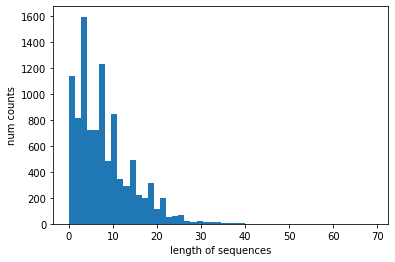

In [22]:
# 최대, 평균 길이 파악 후 히스토그램으로 시각화

print('최대 길이:', max(len(review) for review in X_train))
print('평균 길이:', sum(map(len, X_train))/len(X_train))

plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of sequences')
plt.ylabel('num counts')
plt.show()

### 정수 인코딩된 test 문장의 길이 파악

최대 길이: 39
평균 길이: 7.875095785440613


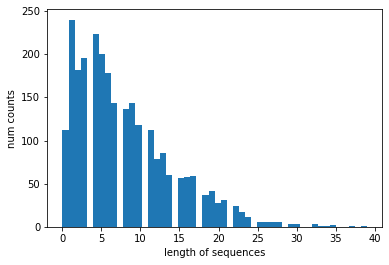

In [23]:
# 최대, 평균 길이 파악 후 히스토그램으로 시각화

print('최대 길이:', max(len(review) for review in X_test))
print('평균 길이:', sum(map(len, X_test))/len(X_test))

plt.hist([len(review) for review in X_test], bins=50)
plt.xlabel('length of sequences')
plt.ylabel('num counts')
plt.show()

## 전처리에 사용할 다양한 토크나이저 작동방식 비교  
Modeling에서 BERT 계열 모델을 사용할 예정이라 BERT 계열 토크나이저들의 작동방식을 비교하고자 함  
train에 존재하는 문장 중 하나를 골라 sample로 사용

In [24]:
# sample: train에 존재하는 문장

sample = "What?! What is with everybody? It's Thanksgiving, not...Truth-Day!"

### BERT 계열 토크나이저

In [25]:
# 'bert-base-cased'

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

# 토크나이저 작동방식 확인
result = tokenizer.tokenize(sample)
print(result, '\n')
encoded = tokenizer(sample)
print(encoded, '\n')
decoded = tokenizer.decode(encoded['input_ids'])
print(decoded)

['What', '?', '!', 'What', 'is', 'with', 'everybody', '?', 'It', "'", 's', 'Thanksgiving', ',', 'not', '.', '.', '.', 'Truth', '-', 'Day', '!'] 

{'input_ids': [101, 1327, 136, 106, 1327, 1110, 1114, 10565, 136, 1135, 112, 188, 17148, 117, 1136, 119, 119, 119, 9907, 118, 2295, 106, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]} 

[CLS] What?! What is with everybody? It's Thanksgiving, not... Truth - Day! [SEP]


In [26]:
# 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# 토크나이저 작동방식 확인
result = tokenizer.tokenize(sample)
print(result, '\n')
encoded = tokenizer(sample)
print(encoded, '\n')
decoded = tokenizer.decode(encoded['input_ids'])
print(decoded)

['what', '?', '!', 'what', 'is', 'with', 'everybody', '?', 'it', "'", 's', 'thanksgiving', ',', 'not', '.', '.', '.', 'truth', '-', 'day', '!'] 

{'input_ids': [101, 2054, 1029, 999, 2054, 2003, 2007, 7955, 1029, 2009, 1005, 1055, 15060, 1010, 2025, 1012, 1012, 1012, 3606, 1011, 2154, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]} 

[CLS] what?! what is with everybody? it's thanksgiving, not... truth - day! [SEP]


### cased vs uncased
위 출력결과를 보면 input_ids의 번호 종류, 그리고 다시 복원했을 때의 대소문자에서 차이가 있음!  

cased는 대소문자 그대로 둠, uncased는 모두 소문자로 통일  
같은 단어를 같다고 인식하기 위해선 uncased가 더 좋음(실제로 예측 성능 결과도 더 좋았음)

In [27]:
# 'bert-large-uncased'

tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')

# 토크나이저 작동방식 확인
result = tokenizer.tokenize(sample)
print(result, '\n')
encoded = tokenizer(sample)
print(encoded, '\n')
decoded = tokenizer.decode(encoded['input_ids'])
print(decoded)

['what', '?', '!', 'what', 'is', 'with', 'everybody', '?', 'it', "'", 's', 'thanksgiving', ',', 'not', '.', '.', '.', 'truth', '-', 'day', '!'] 

{'input_ids': [101, 2054, 1029, 999, 2054, 2003, 2007, 7955, 1029, 2009, 1005, 1055, 15060, 1010, 2025, 1012, 1012, 1012, 3606, 1011, 2154, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]} 

[CLS] what?! what is with everybody? it's thanksgiving, not... truth - day! [SEP]


### base-uncased vs large-uncased  
토큰화 위치, 부여 번호('input_ids'), 복원했을 때의 문장에서 차이 없었음  
그러나 아래와 같은 차이가 존재(https://iq.opengenus.org/bert-base-vs-bert-large/)  
- encoder 층 개수 차이: base(12 layers), large(24 layers)  
층이 늘어난 만큼 attention head와 parameter(가중치) 개수도 늘어남  
- attention head 수 차이: base(12개), large(16개)  
- parameter 수 차이: base(1억1천만, 110 million), largea(3억4천만, 340 million)
- hidden layer 수 차이: base(768 layers), large(1024 layers)

In [28]:
# 'bert-large-uncased-whole-word-masking'

tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased-whole-word-masking')

# 토크나이저 작동방식 확인
result = tokenizer.tokenize(sample)
print(result, '\n')
encoded = tokenizer(sample)
print(encoded, '\n')
decoded = tokenizer.decode(encoded['input_ids'])
print(decoded)

['what', '?', '!', 'what', 'is', 'with', 'everybody', '?', 'it', "'", 's', 'thanksgiving', ',', 'not', '.', '.', '.', 'truth', '-', 'day', '!'] 

{'input_ids': [101, 2054, 1029, 999, 2054, 2003, 2007, 7955, 1029, 2009, 1005, 1055, 15060, 1010, 2025, 1012, 1012, 1012, 3606, 1011, 2154, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]} 

[CLS] what?! what is with everybody? it's thanksgiving, not... truth - day! [SEP]


### uncased vs uncased-whole-word-masking
이 역시 서로 토큰화 위치, 부여 번호('input_ids'), 복원했을 때의 문장에서 차이 없었음  
그러나 마스킹하는 방식에 있어서 차이가 존재!  
- 지금까지의 토크나이저의 경우 마스킹이 한 단어 내에서도 일부만 가리는 식으로 위치할 수 있는데, whole-word-masking에서는 한 단어로 되어 있는 것은 전부 마스킹 처리가 된다는 차이가 있음

### EmoBERTa 토크나이저  
EmoBERTa: pre-trained "roberta-large" 모델에서 시작한 토크나이저로, 대화 상황의 텍스트를 사전학습하여 담화 내에서의 감정 변화 및 분석에 특화된 토크나이저  
(참고 논문: https://arxiv.org/pdf/2108.12009.pdf)

base와 large의 차이는 앞서 BERT와 동일!  

In [29]:
# 'tae898/emoberta-base'
tokenizer = AutoTokenizer.from_pretrained('tae898/emoberta-base')

# 토크나이저 작동방식 확인
result = tokenizer.tokenize(sample)
print(result, '\n')
encoded = tokenizer(sample)
print(encoded, '\n')
decoded = tokenizer.decode(encoded['input_ids'])
print(decoded)

['What', '?!', 'ĠWhat', 'Ġis', 'Ġwith', 'Ġeverybody', '?', 'ĠIt', "'s", 'ĠThanksgiving', ',', 'Ġnot', '...', 'Truth', '-', 'Day', '!'] 

{'input_ids': [0, 2264, 17516, 653, 16, 19, 3370, 116, 85, 18, 8126, 6, 45, 734, 41286, 12, 10781, 328, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]} 

<s>What?! What is with everybody? It's Thanksgiving, not...Truth-Day!</s>


In [30]:
# 'tae898/emoberta-large'
tokenizer = AutoTokenizer.from_pretrained('tae898/emoberta-large')

# 토크나이저 작동방식 확인
result = tokenizer.tokenize(sample)
print(result, '\n')
encoded = tokenizer(sample)
print(encoded, '\n')
decoded = tokenizer.decode(encoded['input_ids'])
print(decoded)

['What', '?!', 'ĠWhat', 'Ġis', 'Ġwith', 'Ġeverybody', '?', 'ĠIt', "'s", 'ĠThanksgiving', ',', 'Ġnot', '...', 'Truth', '-', 'Day', '!'] 

{'input_ids': [0, 2264, 17516, 653, 16, 19, 3370, 116, 85, 18, 8126, 6, 45, 734, 41286, 12, 10781, 328, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]} 

<s>What?! What is with everybody? It's Thanksgiving, not...Truth-Day!</s>


### BERT-uncased vs EmoBERTa   
- 대소문자 소문자로 통일 여부: bert-uncased(o), emoberta(x) -> emoberta에는 아직 uncased가 구현되어 있지 않음, 따라서 'Utterance'들을 입력할 때 `lower()`로 낮춰주는 작업을 수동으로 추가해야 할 것 같음 -> 해봤더니 오히려 성능 안좋았음  
- 'input_ids'의 숫자가 다른 것은 너무 당연하니 pass
- 문장의 앞뒤에 추가되는 토큰: bert-uncased([CLS],[SEP]), emoberta(s,/s), 이거는 BERT와 RoBERTa의 차이에서 비롯된 것  


- **가장 중요해 보였던 차이**: bert 토크나이저에는 `'token_type_ids'`가 있었지만 **emoberta 토크나이저에는 아예 없었음!!** 이 부분 때문에 추후 모델 구조를 짤때 BERT와 EmoBERTa 중 어떤 것이냐에 따라 다르게 짜야 하였음

# Preprocessing

## test의 일부 speaker 변경

앞서 EDA 과정에서 발견한 이름이 달랐던 test의 상위 이름 6명을 train과 맞게 변경:

In [31]:
# 변경 전

test['Speaker'].value_counts().head(10)

Joeyy       411
Chadler     379
Rossi       373
Rachell     356
Mornica     346
Phoebe      291
Janice       31
Emily        16
Director     16
Gunther      13
Name: Speaker, dtype: int64

In [33]:
for _ in tqdm(range(len(test))):
    test['Speaker'].replace('Joeyy', 'Joey', inplace=True)
    test['Speaker'].replace('Chadler', 'Chandler', inplace=True)
    test['Speaker'].replace('Rossi', 'Ross', inplace=True)
    test['Speaker'].replace('Rachell', 'Rachel', inplace=True)
    test['Speaker'].replace('Mornica', 'Monica', inplace=True)

100%|██████████| 2610/2610 [00:02<00:00, 913.37it/s]


In [34]:
# 변경 후 

test['Speaker'].value_counts().head(10)

Joey        411
Chandler    379
Ross        373
Rachel      356
Monica      346
Phoebe      291
Janice       31
Emily        16
Director     16
Gunther      13
Name: Speaker, dtype: int64

In [35]:
# 재확인

test

,ID,Utterance,Speaker,Dialogue_ID
0,TEST_0000,Why do all the coffee cups have figures below?,Mark,0
1,TEST_0001,"Oh. It's so Monica can follow. Of this way, if...",Rachel,0
2,TEST_0002,You know what?,Rachel,0
3,TEST_0003,"Come on, Lydia, you can do it.",Joey,1
4,TEST_0004,To push!,Joey,1
...,...,...,...,...
2605,TEST_2605,"Yeah, I mean, go Ross, no one will even notice...",Rachel,279
2606,TEST_2606,They don't listen to me?,Ross,279
2607,TEST_2607,"Of course, they listen to you! Everyone listen...",Rachel,279
2608,TEST_2608,"Monica, do you really think I should try this ...",Ross,279


## train, test의 Utterance 변형

EmoBERTa 논문을 보니 입력 데이터를 "Speaker : Utterance" 식으로 만들어주었음  
따라서 train, test의 'Speaker' column을 'Utterance'와 합치는 식으로 변형 시도

### train

In [36]:
# 변형 전

train.head()

,ID,Utterance,Speaker,Dialogue_ID,Target
0,TRAIN_0000,also I was the point person on my company’s tr...,Chandler,0,neutral
1,TRAIN_0001,You must’ve had your hands full.,The Interviewer,0,neutral
2,TRAIN_0002,That I did. That I did.,Chandler,0,neutral
3,TRAIN_0003,So let’s talk a little bit about your duties.,The Interviewer,0,neutral
4,TRAIN_0004,My duties? All right.,Chandler,0,surprise


In [37]:
train['Utterance'] = train['Speaker'] + " : " + train['Utterance']

In [38]:
# 변형 후

train.head()

,ID,Utterance,Speaker,Dialogue_ID,Target
0,TRAIN_0000,Chandler : also I was the point person on my c...,Chandler,0,neutral
1,TRAIN_0001,The Interviewer : You must’ve had your hands f...,The Interviewer,0,neutral
2,TRAIN_0002,Chandler : That I did. That I did.,Chandler,0,neutral
3,TRAIN_0003,The Interviewer : So let’s talk a little bit a...,The Interviewer,0,neutral
4,TRAIN_0004,Chandler : My duties? All right.,Chandler,0,surprise


### test

In [39]:
# 변형 전

test.tail()

,ID,Utterance,Speaker,Dialogue_ID
2605,TEST_2605,"Yeah, I mean, go Ross, no one will even notice...",Rachel,279
2606,TEST_2606,They don't listen to me?,Ross,279
2607,TEST_2607,"Of course, they listen to you! Everyone listen...",Rachel,279
2608,TEST_2608,"Monica, do you really think I should try this ...",Ross,279
2609,TEST_2609,I think you look good.,Monica,279


In [40]:
test['Utterance'] = test['Speaker'] + " : " + test['Utterance']

In [41]:
# 변형 후

test.tail()

,ID,Utterance,Speaker,Dialogue_ID
2605,TEST_2605,"Rachel : Yeah, I mean, go Ross, no one will ev...",Rachel,279
2606,TEST_2606,Ross : They don't listen to me?,Ross,279
2607,TEST_2607,"Rachel : Of course, they listen to you! Everyo...",Rachel,279
2608,TEST_2608,"Ross : Monica, do you really think I should tr...",Ross,279
2609,TEST_2609,Monica : I think you look good.,Monica,279


## Label encoding  
sklearn.preprocessing의 LabelEncoder() 사용

In [42]:
# 변환 전

train['Target']

0        neutral
1        neutral
2        neutral
3        neutral
4       surprise
          ...   
9984     neutral
9985     neutral
9986    surprise
9987     neutral
9988         joy
Name: Target, Length: 9989, dtype: object

In [43]:
# train의 Target column을 범주로 변환

le = LabelEncoder()
le = le.fit(train['Target'])
train['Target'] = le.transform(train['Target'])

In [44]:
# 변환 후

train['Target']

0       4
1       4
2       4
3       4
4       6
       ..
9984    4
9985    4
9986    6
9987    4
9988    3
Name: Target, Length: 9989, dtype: int64

In [45]:
# 범주 종류 확인

le.classes_

array(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness',
       'surprise'], dtype=object)

## Train/Validation set 분리  
train의 'Dialogue_ID' column을 기준으로 1016개(98%)/23개(2%)로 분리하고자 함

In [46]:
valid = train[~train['Dialogue_ID'].isin([i for i in range(1016)])].reset_index(drop=True)
train = train[train['Dialogue_ID'].isin([i for i in range(1016)])].reset_index(drop=True)

train_len = len(train)
valid_len = len(valid)

print(train_len)
print(valid_len)

9725
264


## CustomDataset 클래스 생성
getitem 부분 정의 시 **max_length**는 EDA에서 파악한 정수 인코딩된 문장 길이를 토대로 잘리는 부분 없이 넉넉하게 128로 지정하였음

In [47]:
# 사용할 토크나이저 지정

tokenizer = AutoTokenizer.from_pretrained('tae898/emoberta-base')

In [48]:
# CustomDataset 클래스 정의

class CustomDataset(Dataset):
    def __init__(self, data, mode='train'):
        self.dataset = data
        self.tokenizer = tokenizer
        self.mode = mode
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        text = self.dataset['Utterance'][idx]
        #text = text.lower()
        inputs = self.tokenizer(text, padding='max_length', max_length=128,
                               truncation=True, return_tensors='pt')
        input_ids = inputs['input_ids'][0]
        attention_mask = inputs['attention_mask'][0]
        
        if self.mode == 'train':
            y = self.dataset['Target'][idx]
            return input_ids, attention_mask, y
        else:
            return input_ids, attention_mask

In [49]:
# train/valid 데이터셋, 데이터로더 생성
# BS 사용

train = CustomDataset(train, mode='train')
valid = CustomDataset(valid, mode='train')

train_dataloader = DataLoader(train, batch_size=BS, shuffle=True)
valid_dataloader = DataLoader(valid, batch_size=BS, shuffle=False)

# Modeling

## 주요 함수 정의

### class BaseModel 정의

In [50]:
class BaseModel(nn.Module):
    def __init__(self, dropout=0.5, num_classes=len(le.classes_)):
        super(BaseModel, self).__init__()
        
        self.bert = AutoModel.from_pretrained('tae898/emoberta-base')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, num_classes) # 768: base 임베딩 벡터의 hidden layer 차원
        self.relu = nn.ReLU()
        
    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        
        return final_layer

### train 함수 정의

In [51]:
# EPOCHS 사용

def train(model, optimizer, train_loader, test_loader, device):
    model.to(device) 
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_score = 0
    #best_model = "None"
    
    for epoch_num in range(EPOCHS): # 여기!
        model.train() # train 모드로 변경
        train_loss = []
        for input_ids, attention_mask, train_label in tqdm(train_loader):
            optimizer.zero_grad()
            
            train_label = train_label.to(device)
            input_id = input_ids.to(device)
            mask = attention_mask.to(device)
            
            output = model(input_id, mask) # forward 함수와 입력 형식 맞춰줌
            
            batch_loss = criterion(output, train_label.long())
            train_loss.append(batch_loss.item())
            
            batch_loss.backward()
            optimizer.step()
            
        val_loss, val_score = validation(model, criterion, test_loader, device)
        print(f'Epoch [{epoch_num}], Train Loss : [{np.mean(train_loss) :.5f}] Val Loss : [{np.mean(val_loss) :.5f}] Val F1 Score : [{val_score:.5f}]')
        
        if best_score < val_score:
            #best_model = model
            best_score = val_score
            torch.save(model.state_dict(), './model/best_emoberta_base_model.pth',
                      _use_new_zipfile_serialization=False)
            
#    return best_model

### validation 함수 정의

In [52]:
def validation(model, criterion, test_loader, device):
    model.eval() # evaluation 모드로 변경
    val_loss, model_preds, true_labels = [], [], []
    
    # pytorch의 autograd engine을 비활성화하여 gradient를 계산하지 않도록 함
    # 보통 model.eval()과 함께 쓰임
    with torch.no_grad():
        for input_ids, attention_mask, valid_label in tqdm(test_loader):
            valid_label = valid_label.to(device)
            input_id = input_ids.to(device)
            mask = attention_mask.to(device)
            
            output = model(input_id, mask)
            
            batch_loss = criterion(output, valid_label.long())
            val_loss.append(batch_loss.item())
            
            model_preds += output.argmax(1).detach().cpu().numpy().tolist()
            true_labels += valid_label.detach().cpu().numpy().tolist()
        val_f1 = f1_score(true_labels, model_preds, average="macro")
    
    return val_loss, val_f1

## 모델 학습

In [53]:
# LR 사용

model = BaseModel()
model.eval()
optimizer = Adam(params = model.parameters(), lr=LR)

train(model, optimizer, train_dataloader, valid_dataloader, device)

Some weights of the model checkpoint at tae898/emoberta-base were not used when initializing RobertaModel: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at tae898/emoberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 33/33 [

Epoch [0], Train Loss : [0.99802] Val Loss : [0.92437] Val F1 Score : [0.44305]


100%|██████████| 33/33 [00:00<00:00, 44.52it/s]


Epoch [1], Train Loss : [0.80344] Val Loss : [0.90892] Val F1 Score : [0.54457]


100%|██████████| 33/33 [00:00<00:00, 44.45it/s]


Epoch [2], Train Loss : [0.66720] Val Loss : [0.92293] Val F1 Score : [0.55155]


100%|██████████| 33/33 [00:00<00:00, 44.70it/s]


Epoch [3], Train Loss : [0.55763] Val Loss : [1.00066] Val F1 Score : [0.55593]


100%|██████████| 33/33 [00:00<00:00, 44.30it/s]

Epoch [4], Train Loss : [0.45546] Val Loss : [1.16590] Val F1 Score : [0.55022]


## 모델 로드

In [54]:
infer_model = BaseModel()
infer_model.load_state_dict(torch.load('./model/best_emoberta_base_model.pth'))
infer_model.eval()

Some weights of the model checkpoint at tae898/emoberta-base were not used when initializing RobertaModel: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at tae898/emoberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BaseModel(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), ep

## 모델 예측

### test 데이터로더 생성

In [55]:
# BS 사용

test = CustomDataset(test, mode="test")
test_dataloader = DataLoader(test, batch_size=BS, shuffle=False)

### inference 함수 정의

In [56]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval() # evaluation 모드로 변경
    test_predict = []
    
    for input_ids, attention_mask in tqdm(test_loader):
        input_id = input_ids.to(device)
        mask = attention_mask.to(device)
        
        y_pred = model(input_id, mask)
        test_predict += y_pred.argmax(1).detach().cpu().numpy().tolist()
    print('Done.')
    return test_predict

In [57]:
preds = inference(infer_model, test_dataloader, device)

100%|██████████| 327/327 [00:07<00:00, 43.73it/s]

Done.


# Result

In [58]:
# 앞에 10개만 label 확인

print(preds[:10])

[6, 4, 4, 4, 3, 3, 3, 3, 5, 3]


In [59]:
# LabelEncoder로 숫자로 인코딩했던 값을 다시 원래 문자 label로 변환

preds = le.inverse_transform(preds)
preds[:10]

array(['surprise', 'neutral', 'neutral', 'neutral', 'joy', 'joy', 'joy',
       'joy', 'sadness', 'joy'], dtype=object)

In [60]:
# preds에 존재하는 감정 종류 파악

unique, counts = np.unique(preds, return_counts=True)
uniq_cnt_dict = dict(zip(unique, counts))
uniq_cnt_dict

{'anger': 311,
 'disgust': 25,
 'fear': 33,
 'joy': 444,
 'neutral': 1383,
 'sadness': 161,
 'surprise': 253}

## 예측 결과물 Sumit

In [61]:
submit = pd.read_csv('./data/sample_submission.csv')
submit.head()

,ID,Target
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0


In [62]:
submit['Target'] = preds
submit.head()

,ID,Target
0,TEST_0000,surprise
1,TEST_0001,neutral
2,TEST_0002,neutral
3,TEST_0003,neutral
4,TEST_0004,joy


In [63]:
submit.to_csv('./predictions/best_emoberta_base_model.csv', index=False)

# END